# Code for the construction and analysis of content networks

In this notebook we compile the code for constructing and analysing the content networks in the paper *Complex networks approach to curriculum analysis and subject integration: a case study on Physics and Mathematics*.

In [27]:
# needed libraries
import networkx as nx
import pandas as pd
from random import sample
import matplotlib.pyplot as plt
from scipy import stats

# Functions

def read_data(fname='network_data.csv'):
    """
    Reads the data that we have already.
    """
    df_continguts = pd.read_csv(fname,sep=',')
    return df_continguts

def full_undir_network(df):
    """
    create the undirected network from the data taking into account directed 
    and undirected relations and putting them all as undirected
    """
    g = nx.Graph()
    for index,row in df.iterrows():
        if not pd.isnull(row['Relacionat amb']):
            neighbors = row['Relacionat amb'].split(',')
            for neigh in neighbors:
                g.add_edge(row['Id'],neigh)
        if not pd.isnull(row['Necessari per']):
            neighbors = row['Necessari per'].split(',')
            for neigh in neighbors:
                g.add_edge(row['Id'],neigh)
    return g

def full_dir_network(df):
    """
    create the directed network from the data taking into account directed 
    and undirected relations and putting the undirected as going in both directions
    """
    g = nx.DiGraph()
    for index,row in df.iterrows():
        if not pd.isnull(row['Relacionat amb']):
            neighbors = row['Relacionat amb'].split(',')
            for neigh in neighbors:
                g.add_edge(row['Id'],neigh)
                g.add_edge(neigh,row['Id'])
        if not pd.isnull(row['Necessari per']):
            neighbors = row['Necessari per'].split(',')
            for neigh in neighbors:
                g.add_edge(row['Id'],neigh)
    return g

In [62]:
# here choose which network you want to examine
# In the next three lines of code, choose only one; 
# only physics, only math or both

materia = ['Física']
materia = ['Matemàtiques II']
materia = ['Física','Matemàtiques II']

<>:50: SyntaxWarning: invalid escape sequence '\h'
<>:58: SyntaxWarning: invalid escape sequence '\h'
<>:50: SyntaxWarning: invalid escape sequence '\h'
<>:58: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_79587/2287601019.py:50: SyntaxWarning: invalid escape sequence '\h'
  fout.write("Identificador & Matèria & Bloc & Contingut & Grau & Proximitat & Intermediació\\\\ \hline \n")
/tmp/ipykernel_79587/2287601019.py:58: SyntaxWarning: invalid escape sequence '\h'
  fout.write(node+" & "+mat+" & "+bloc+" & "+cont+" & " +str(row['degree'])+" & "+str(round(row['closeness'],3))+" & "+str(round(row['betweenness'],3))+" \\\\ \hline \n")


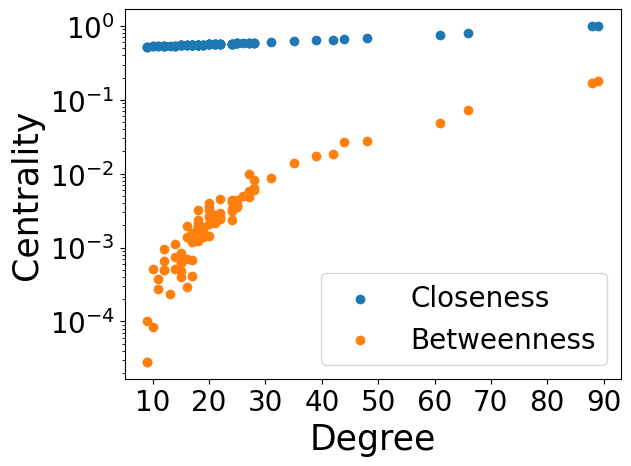

In [63]:
df_continguts = read_data()

df_continguts = df_continguts[df_continguts['Matèria'].isin(materia)]
g = full_undir_network(df_continguts)
nodes = list(g.nodes())
if materia == ['Matemàtiques II']:
    aux = 'F'
elif materia == ['Física']:
    aux = 'M'
else:
    aux = 'N'
for node in nodes:
    mat = node[0]
    if mat == aux:
        g.remove_node(node)
bloc_dict = dict()
mat_dict = dict()
cont_dict = dict()
for node in g.nodes():
    # print(node,list(df_fisica[df_fisica['Id']==node]['Bloc']))
    bloc_dict[node] = list(df_continguts[df_continguts['Id']==node]['Bloc'])[0]
    mat_dict[node] = list(df_continguts[df_continguts['Id']==node]['Matèria'])[0]
    cont_dict[node] = list(df_continguts[df_continguts['Id']==node]['Contingut'])[0]
bloc_list = list(set(bloc_dict.values()))
color_dict = dict()
clist = []
for node in g.nodes():
    color_dict[node] = bloc_list.index(bloc_dict[node])
    clist.append(bloc_list.index(bloc_dict[node])) 
nx.set_node_attributes(g,bloc_dict,name='Bloc')
nx.set_node_attributes(g,mat_dict,name='Materia')
nx.set_node_attributes(g,cont_dict,name='Contingut')
nx.set_node_attributes(g,color_dict,name='color')
deg = dict(nx.degree(g))
df_centralities = pd.DataFrame.from_dict({
    'node': list(deg.keys()),
    'degree': list(deg.values())
})
# closeness
cc = nx.closeness_centrality(g)
df_centralities['closeness'] = df_centralities['node'].map(cc)
# betweenness
bc = nx.betweenness_centrality(g)
df_centralities['betweenness'] = df_centralities['node'].map(bc)

df_centralities = df_centralities.sort_values('degree', ascending=False)
df_centralities.head(10)
# %%
fout = open('table_degree_'+'_'.join(materia)+'.tex','w')
fout.write("Identificador & Matèria & Bloc & Contingut & Grau & Proximitat & Intermediació\\\\ \hline \n")
i=0
for index,row in df_centralities.iterrows():
    if i < 10:
        node = row['node']
        mat = mat_dict[node]
        bloc = bloc_dict[node]
        cont = cont_dict[node]
        fout.write(node+" & "+mat+" & "+bloc+" & "+cont+" & " +str(row['degree'])+" & "+str(round(row['closeness'],3))+" & "+str(round(row['betweenness'],3))+" \\\\ \hline \n")
        i+=1

fout.close()
plt.scatter(list(df_centralities['degree']), list(df_centralities['closeness']), label='Closeness')
plt.scatter(list(df_centralities['degree']), list(df_centralities['betweenness']), label='Betweenness')
plt.yscale('log')
plt.xlabel('Degree', fontsize=25)
plt.ylabel('Centrality', fontsize=25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
if materia not in [['Física'], ['Matemàtiques II']]:
    plt.legend(fontsize = 20)
plt.savefig('ENG_centralitats_'+'_'.join(['_'.join(x.split()) for x in materia])+'.png',bbox_inches='tight')
plt.savefig('ENG_centralitats_'+'_'.join(['_'.join(x.split()) for x in materia])+'.pdf',bbox_inches='tight')


df_centralities = df_centralities.sort_values('degree', ascending=False)
ranking_deg = list(df_centralities['degree'])

ranking_closeness = list(df_centralities['closeness'])

ranking_betweenness = list(df_centralities['betweenness'])

df_rankings = pd.DataFrame([ranking_deg,ranking_closeness,ranking_betweenness])
df_rankings = df_rankings.transpose()
df_rankings.columns = ['Degree', 'Closeness', 'Betweenness']


corr_rankings = df_rankings.corr(method='spearman')

fout = open('corr_centralitats_'+'_'.join(['_'.join(x.split()) for x in materia])+'.txt','w')

res_deg_Betw = stats.spearmanr([ranking_deg,ranking_betweenness],axis=1)
fout.write('deg-Betw:'+str(res_deg_Betw.statistic)+' '+str(res_deg_Betw.pvalue)+'\n')
res_deg_close = stats.spearmanr([ranking_deg,ranking_closeness],axis=1)
fout.write('deg-close:'+str(res_deg_close.statistic)+' '+str(res_deg_close.pvalue)+'\n')
res_close_Betw = stats.spearmanr([ranking_closeness,ranking_betweenness],axis=1)
fout.write('close-Betw:'+str(res_close_Betw.statistic)+' '+str(res_close_Betw.pvalue)+'\n')

fout.close()


## Robustness agains use of directionality

Here we construct the network having into account directed and undirected edges. We treat the network as a directed graph and undirected edges as the existence of the edge in both directions. We will then compute on this network in-degree, out-degree and the directed versions of closeness and betweenness. Finally we will compare the results of the centralities in both networks by computing the correlation among centralities


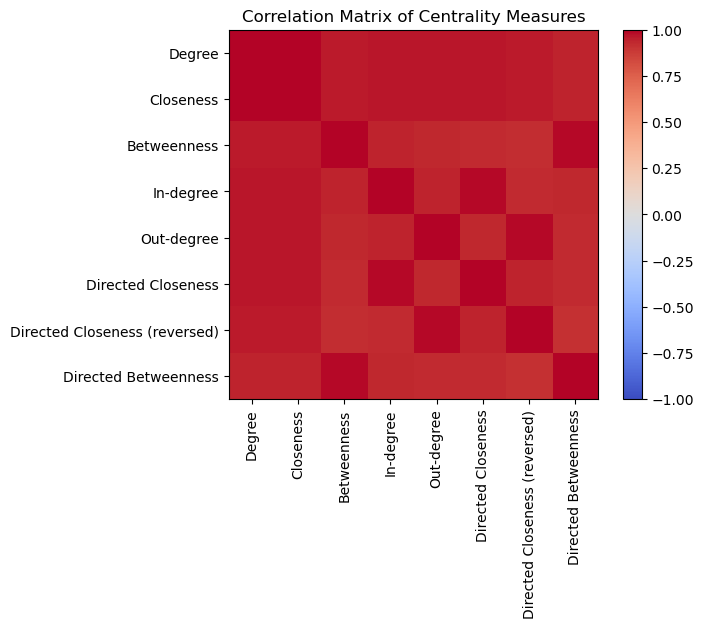

Minimum correlation value: 0.9070871311039168
Minimum absolute correlation value: 0.9070871311039168


In [64]:
import networkx as nx
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Constructing the undirected network
g_undir = full_undir_network(df_continguts)
nodes = list(g_undir.nodes())
if materia == ['Matemàtiques II']:
    aux = 'F'
elif materia == ['Física']:
    aux = 'M'
else:
    aux = 'N'
for node in nodes:
    mat = node[0]
    if mat == aux:
        g_undir.remove_node(node)
# Degree centrality for undirected network
undir_deg = dict(g_undir.degree())

# Closeness centrality for undirected network
undir_closeness = nx.closeness_centrality(g_undir)

# Betweenness centrality for undirected network
undir_betweenness = nx.betweenness_centrality(g_undir)

g_dir = full_dir_network(df_continguts)
nodes = list(g_dir.nodes())
if materia == ['Matemàtiques II']:
    aux = 'F'
elif materia == ['Física']:
    aux = 'M'
else:
    aux = 'N'
for node in nodes:
    mat = node[0]
    if mat == aux:
        g_dir.remove_node(node)

in_deg = dict(g_dir.in_degree())
out_deg = dict(g_dir.out_degree())
closeness = nx.closeness_centrality(g_dir)
closeness_reversed = nx.closeness_centrality(g_dir.reverse())
betweenness = nx.betweenness_centrality(g_dir)

# Correlations among centrality measures
corr_undir = pd.DataFrame({'Degree': undir_deg, 'Closeness': undir_closeness, 'Betweenness': undir_betweenness})
corr_dir = pd.DataFrame({'In-degree': in_deg, 'Out-degree': out_deg, 'Directed Closeness': closeness, 'Directed Closeness (reversed)': closeness_reversed, 'Directed Betweenness': betweenness})

# Correlation matrix
corr_matrix = pd.concat([corr_undir, corr_dir], axis=1)

# Plotting correlation matrix
plt.imshow(corr_matrix.corr(method='spearman'), cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title('Correlation Matrix of Centrality Measures')
plt.savefig('corr_centralitats_dir_undir_'+'_'.join(['_'.join(x.split()) for x in materia])+'.png',bbox_inches='tight')
plt.show()


# Minimum correlation value
min_corr = corr_matrix.corr(method='spearman').min().min()

# Minimum absolute correlation value
min_abs_corr = np.abs(corr_matrix.corr(method='spearman')).min().min()

print("Minimum correlation value:", min_corr)
print("Minimum absolute correlation value:", min_abs_corr)

In [65]:
# undir_deg = dict(g_undir.degree())
# undir_closeness = nx.closeness_centrality(g_undir)
# undir_betweenness = nx.betweenness_centrality(g_undir)

# in_deg = dict(g_dir.in_degree())
# out_deg = dict(g_dir.out_degree())
# closeness = nx.closeness_centrality(g_dir)
# closeness_reversed = nx.closeness_centrality(g_dir.reverse())
# betweenness = nx.betweenness_centrality(g_dir)



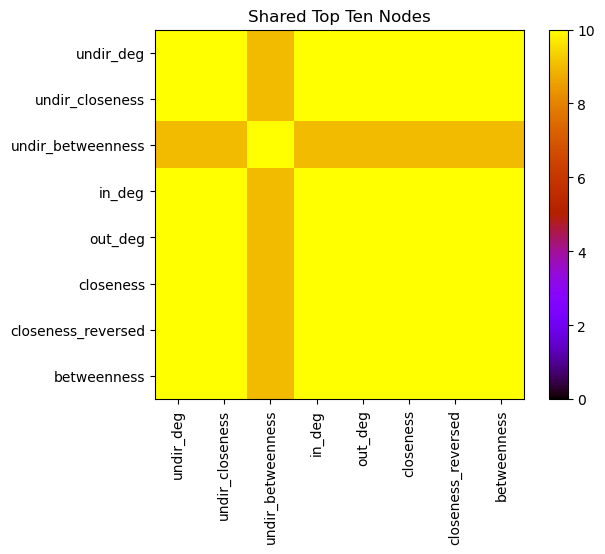

9.0


In [66]:
import numpy as np

import matplotlib.pyplot as plt

# Define the dictionaries
dictionaries = [undir_deg, undir_closeness, undir_betweenness, in_deg, out_deg, closeness, closeness_reversed, betweenness]

# Initialize an empty matrix
matrix = np.zeros((len(dictionaries), len(dictionaries)))

def jaccard_index(dict1, dict2):
    keys1 = set(sorted(dict1, key=dict1.get, reverse=True)[:10])
    keys2 = set(sorted(dict2, key=dict2.get, reverse=True)[:10])
    intersection = keys1.intersection(keys2)
    union = keys1.union(keys2)
    # return len(intersection) / len(union)
    return len(intersection) #/ len(union)

# Calculate the Jaccard index for each pair of dictionaries
for i in range(len(dictionaries)):
    for j in range(len(dictionaries)):
        dict1 = dictionaries[i]
        dict2 = dictionaries[j]
        matrix[i, j] = jaccard_index(dict1, dict2)

# Plot the matrix
plt.imshow(matrix, cmap='gnuplot', interpolation='nearest', vmin=0, vmax=10)
plt.colorbar()
plt.xticks(range(len(dictionaries)), ['undir_deg', 'undir_closeness', 'undir_betweenness', 'in_deg', 'out_deg', 'closeness', 'closeness_reversed', 'betweenness'], rotation=90)
plt.yticks(range(len(dictionaries)), ['undir_deg', 'undir_closeness', 'undir_betweenness', 'in_deg', 'out_deg', 'closeness', 'closeness_reversed', 'betweenness'])
plt.title('Shared Top Ten Nodes')
plt.savefig('jaccard_index_'+'_'.join(['_'.join(x.split()) for x in materia])+'.png',bbox_inches='tight')
plt.show()
print(np.min(matrix))